In [165]:
import sys
sys.path.append("../../src/earthtext")

import rasterio
import xarray as xr
import os
from rlxutils import subplots
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from osm import osm
from osm import multilabel
from collections import OrderedDict
import pandas as pd
from progressbar import progressbar as pbar
from joblib import Parallel, delayed
from pyproj import CRS
import numpy as np
epsg4326 = CRS.from_epsg(4326)

get_region_hash = osm.get_region_hash

In [2]:
imgs_folder    = "/opt/data/clay-california-worldcover-rgbnir-vvvh-chips/chips"
osmobjs_folder = "/opt/data/california-worldcover-chips/osm"
master_index   = "/opt/data/california-worldcover-chips.fgb"

In [3]:
from importlib import reload
reload(multilabel)
iosdata = multilabel.ImageOSMData(imgs_folder=imgs_folder, osmobjs_folder=osmobjs_folder, master_index=master_index).init_index()

In [10]:
splits = np.linspace(0, len(iosdata.m), 10).astype(int)
splits[-1]+=1
splits = [[splits[i], splits[i+1]] for i in range(len(splits)-1)]
splits

[[0, 12435],
 [12435, 24871],
 [24871, 37306],
 [37306, 49742],
 [49742, 62177],
 [62177, 74613],
 [74613, 87048],
 [87048, 99484],
 [99484, 111921]]

## create the multilabels

In [11]:
ImageOSMChip = multilabel.ImageOSMChip
r = []

for start,end in splits:
    print (f"\n{start} : {end}", flush=True)
    for chip_id in pbar(iosdata.m.index[start:end]):
        try:
            multilabel_oh = ImageOSMChip(iosdata, chip_id).read_osm().get_multilabel_onehot()
            r.append([chip_id, multilabel_oh])
        except:
            continue



0 : 12435


100% (12435 of 12435) |##################| Elapsed Time: 0:03:41 Time:  0:03:410117



12435 : 24871


100% (12436 of 12436) |##################| Elapsed Time: 0:24:34 Time:  0:24:341208



24871 : 37306


100% (12435 of 12435) |##################| Elapsed Time: 0:06:35 Time:  0:06:352644



37306 : 49742


100% (12436 of 12436) |##################| Elapsed Time: 0:02:11 Time:  0:02:110112



49742 : 62177


100% (12435 of 12435) |##################| Elapsed Time: 0:07:12 Time:  0:07:120330



62177 : 74613


100% (12436 of 12436) |##################| Elapsed Time: 0:08:04 Time:  0:08:040440



74613 : 87048


100% (12435 of 12435) |##################| Elapsed Time: 0:06:26 Time:  0:06:260331



87048 : 99484


100% (12436 of 12436) |##################| Elapsed Time: 0:13:06 Time:  0:13:060652



99484 : 111921


100% (12436 of 12436) |##################| Elapsed Time: 0:08:04 Time:  0:08:041240


## create dataframe with multilabels

In [76]:
rr = [[ri[0]] + list(ri[1]) for ri in r]

In [77]:
code_descriptions = [multilabel.kvmerged.inverse_codes[code] for code in range(multilabel.max_code+1)]
rdf = pd.DataFrame(rr, columns = ['chip_id'] + code_descriptions)
rdf.set_index('chip_id', inplace=True)
rdf = rdf[(rdf.sum(axis=1)>0)]

In [82]:
rdf.head()

,amenity,amenity=parking,building,building=apartments,building=house,building=industrial,building=residential,building=school,building=warehouse,crop,...,water=reservoir,water=river,water=stream,water=wastewater,waterway,waterway=dam,highway=motorway,highway=residential,waterway=river,waterway=stream
chip_id,,,,,,,,,,,,,,,,,,,,,
2d020602331e4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34c5edf7ed602,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
370214ce19e1d,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
371eeed5e3259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
24763185559b0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [133]:
rdf.to_parquet("/opt/data/california-worldcover-chips-osm-multilabels.parquet")

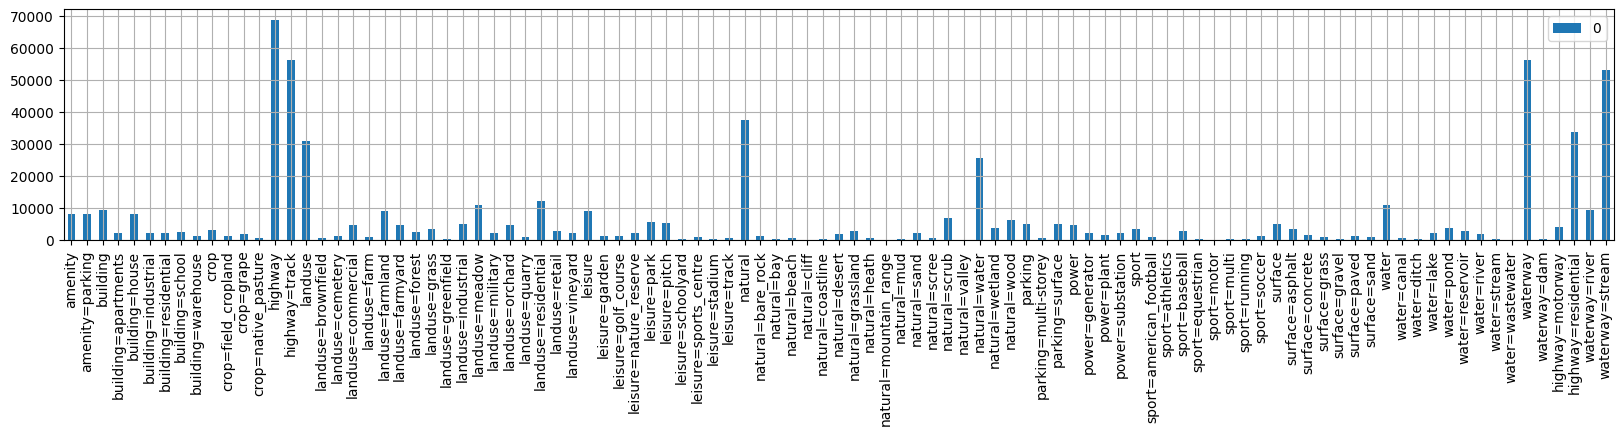

In [134]:
pd.DataFrame([rdf.sum(axis=0)]).T.plot(kind='bar', figsize=(20,3))
plt.grid();

## join with original metadata dataframe

In [142]:
rohe = []
for i in pbar(range(len(rdf))):
    ohe = rdf.values[i]
    labels = [k for k,v in dict(rdf.iloc[i]).items() if v==1]
    rohe.append([rdf.index[i], ohe, labels])

100% (83609 of 83609) |##################| Elapsed Time: 0:00:15 Time:  0:00:150001


In [143]:
rohe = pd.DataFrame(rohe, columns=['chip_id', 'onehot_label', 'string_labels'])
rohe.set_index('chip_id', inplace=True)
rohe

,onehot_label,string_labels
chip_id,,
2d020602331e4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[highway, highway=track]"
34c5edf7ed602,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[amenity, amenity=parking, highway, highway=tr..."
370214ce19e1d,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[highway, highway=track, highway=motorway, hig..."
371eeed5e3259,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[highway, highway=track, highway=motorway, hig..."
24763185559b0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[highway, highway=track]"
...,...,...
38cfd257e94a3,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[amenity, amenity=parking, building, building=..."
16ed63bb1e90e,"[1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, ...","[amenity, amenity=parking, building, building=..."
2926cff9ef2a0,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[amenity, amenity=parking, highway, landuse, l..."


In [168]:
rohem = gpd.GeoDataFrame(rohe.join(iosdata.m), crs=epsg4326)
rohem


,onehot_label,string_labels,col,row,geometry
chip_id,,,,,
2d020602331e4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[highway, highway=track]",122624,111104,"POLYGON ((-114.76000 32.72000, -114.76000 32.7..."
34c5edf7ed602,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[amenity, amenity=parking, highway, highway=tr...",122624,110848,"POLYGON ((-114.76000 32.74133, -114.76000 32.7..."
370214ce19e1d,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[highway, highway=track, highway=motorway, hig...",122368,110848,"POLYGON ((-114.78133 32.74133, -114.78133 32.7..."
371eeed5e3259,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[highway, highway=track, highway=motorway, hig...",122112,110848,"POLYGON ((-114.80267 32.74133, -114.80267 32.7..."
24763185559b0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[highway, highway=track]",122112,110592,"POLYGON ((-114.80267 32.76267, -114.80267 32.7..."
...,...,...,...,...,...
38cfd257e94a3,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[amenity, amenity=parking, building, building=...",68352,92672,"POLYGON ((-119.28267 34.25600, -119.28267 34.2..."
16ed63bb1e90e,"[1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, ...","[amenity, amenity=parking, building, building=...",68608,92672,"POLYGON ((-119.26133 34.25600, -119.26133 34.2..."
2926cff9ef2a0,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[amenity, amenity=parking, highway, landuse, l...",68608,92928,"POLYGON ((-119.26133 34.23467, -119.26133 34.2..."


In [176]:
rohem.to_parquet("/opt/data/california-worldcover-chips-osm-multilabels.parquet")

## visualize some chip

In [155]:
chip_id = rohe.index[np.random.randint(len(rohe))]
c = multilabel.ImageOSMChip(iosdata, chip_id).read_img().read_osm()

In [156]:
c.osm

,tags,geometry,kind,length,area,stags,chip_id
86403427,{'highway': 'turning_circle'},POINT (-121.89809 39.80400),node,0.000000,0.0,highway: turning_circle,0674492cd9a9e
86418353,{'highway': 'turning_circle'},POINT (-121.89872 39.81394),node,0.000000,0.0,highway: turning_circle,0674492cd9a9e
86439339,{'highway': 'turning_circle'},POINT (-121.89921 39.80934),node,0.000000,0.0,highway: turning_circle,0674492cd9a9e
86443322,{'highway': 'turning_circle'},POINT (-121.90350 39.81543),node,0.000000,0.0,highway: turning_circle,0674492cd9a9e
86443328,{'highway': 'turning_circle'},POINT (-121.90348 39.81378),node,0.000000,0.0,highway: turning_circle,0674492cd9a9e
...,...,...,...,...,...,...,...
9393,"{'highway': 'service', 'service': 'driveway'}","LINESTRING (-121.88797 39.80542, -121.88801 39...",way,49.620593,0.0,highway: service\n<br>\nservice: driveway,0674492cd9a9e
9553,{'highway': 'residential'},"LINESTRING (-121.90533 39.81961, -121.90613 39...",way,68.726235,0.0,highway: residential,0674492cd9a9e
9800,{'highway': 'service'},"LINESTRING (-121.88593 39.80435, -121.88590 39...",way,132.024534,0.0,highway: service,0674492cd9a9e
10369,"{'highway': 'service', 'service': 'driveway'}","LINESTRING (-121.89433 39.80421, -121.89418 39...",way,42.016962,0.0,highway: service\n<br>\nservice: driveway,0674492cd9a9e


In [157]:
c.get_multilabel_keyvals()

['building',
 'building=house',
 'highway',
 'highway=track',
 'landuse',
 'landuse=meadow',
 'landuse=orchard',
 'waterway',
 'highway=residential',
 'waterway=stream']

In [158]:
c.get_multilabel_codes()

[2, 4, 13, 14, 15, 26, 28, 93, 96, 98]

In [160]:
rohe.loc[chip_id]

onehot_label     [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...
string_labels    [building, building=house, highway, highway=tr...
Name: 0674492cd9a9e, dtype: object

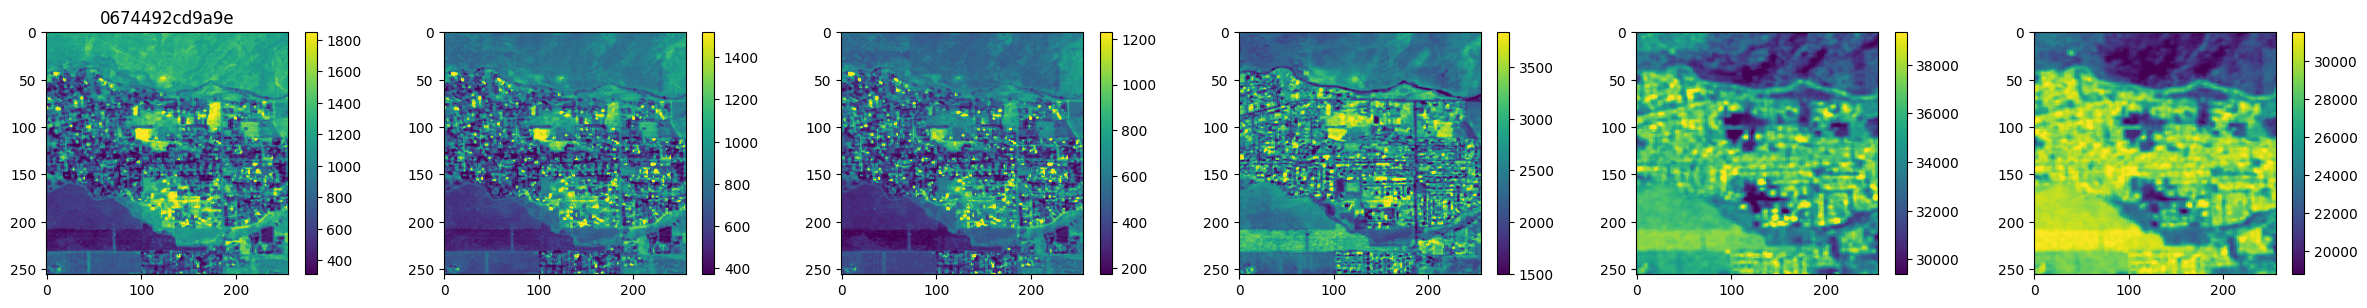

In [159]:
c.show()